In [1]:
# sns.set_palette('colorblind')
# sns.pairplot(data=data, height=3)

In [2]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# from sklearn.externals import joblib


In [3]:
data = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
data.shape

(253680, 22)

In [4]:
#check for completeness of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

                      Diabetes_binary    HighBP  HighChol  CholCheck  \
Diabetes_binary              1.000000  0.263129  0.200276   0.064761   
HighBP                       0.263129  1.000000  0.298199   0.098508   
HighChol                     0.200276  0.298199  1.000000   0.085642   
CholCheck                    0.064761  0.098508  0.085642   1.000000   
BMI                          0.216843  0.213748  0.106722   0.034495   
Smoker                       0.060789  0.096991  0.091299  -0.009929   
Stroke                       0.105816  0.129575  0.092620   0.024158   
HeartDiseaseorAttack         0.177282  0.209361  0.180765   0.044206   
PhysActivity                -0.118133 -0.125267 -0.078046   0.004190   
Fruits                      -0.040779 -0.040555 -0.040859   0.023849   
Veggies                     -0.056584 -0.061266 -0.039874   0.006121   
HvyAlcoholConsump           -0.057056 -0.003972 -0.011543  -0.023730   
AnyHealthcare                0.016255  0.038425  0.042230   0.11

<AxesSubplot:>

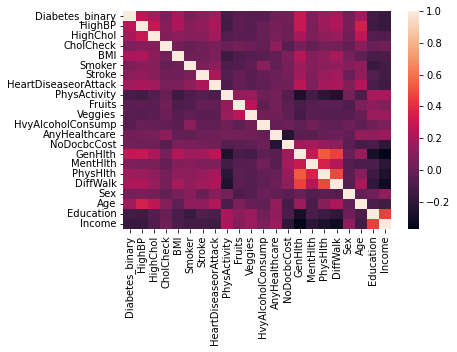

In [5]:
#correlation of every pair of features
#brighter colors indicate more correlation
corr = data.corr()
print(corr)
sns.heatmap(corr, 
         xticklabels=corr.columns, 
         yticklabels=corr.columns)

Initial Data Visualization Interpretations from Heatmap

1. HighBP, HighChol, BMI, HeartDiseaseorAttack, GenHlth, and Age all have significant correlation with the outcome variable.

In [9]:
#Splitting Features and Label
y = data.iloc[:,0]
X = data.iloc[:,1:-1]

In [11]:
#scale data? binary data so we don't need to scale i think

#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 99)



In [12]:
#training and fitting Logistic Regression to model
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train,y_train)

#evaluating model
accuracy = model.score(X_test, y_test)
print("accuracy = ", accuracy * 100, "%")


accuracy =  86.19520655944497 %


In [13]:
print(model.intercept_)
print(model.coef_)

[-7.81134945]
[[ 0.76562293  0.56892039  1.14580062  0.06034257 -0.00737816  0.14679062
   0.22248805 -0.05562699 -0.05303859 -0.04958123 -0.78584189  0.02367027
   0.03776622  0.54459898 -0.00287299 -0.00714963  0.16053828  0.22772974
   0.12574821 -0.06683534]]


Text(0.5, 0, 'Importance')

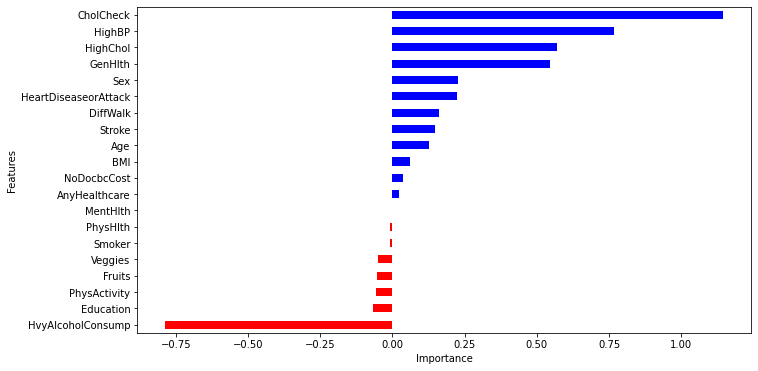

In [23]:
coeff = list(model.coef_[0])
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

Interpretations on the Visualization of the Weights :

1. CholCheck, HighBP, GenHlth, and HighChol have significant influence on the model.
2. HvyAlcoholConsumption has negative influence to the model, meaning that a higher HvyAlcoholConsumption correlates to a person not having diabetes
3. Initial data interpretations, like BMI and Age show that they have a high correlation to the outcome variable, but the model relies more on CholCheck, HighBP, GenHlth, and HighChol instead. (? - data needs to be normalized for this to be an accurate statement) 

In [16]:
#making predictions
predictionProbability = model.predict_proba(X_test)
prediction = model.predict(X_test)
#shows probability of being zlass '0' and class '1'
print('Probability:', predictionProbability)
print('prediction:', prediction)


Probability: [[0.92323838 0.07676162]
 [0.66798027 0.33201973]
 [0.93869112 0.06130888]
 ...
 [0.97580289 0.02419711]
 [0.96929514 0.03070486]
 [0.52017682 0.47982318]]
prediction: [0. 0. 0. ... 0. 0. 0.]


In [17]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, prediction)
print(confusion_matrix)

[[10653   213]
 [ 1538   280]]


Confusion Matrix Interpretations

- True positive is 158168.
- True negative is 27097.
- False positive is 60166.
- False negative is 8249.

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     10866
         1.0       0.57      0.15      0.24      1818

    accuracy                           0.86     12684
   macro avg       0.72      0.57      0.58     12684
weighted avg       0.83      0.86      0.83     12684



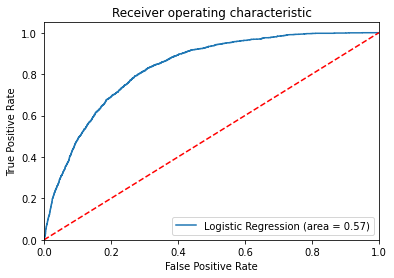

In [19]:
#ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [30]:
'''
# Another way to apply Logistic Regression model to data 
import statsmodels.api as sm
from statsmodels.formula.api import logit

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

# Using Anova to check for significance
model1 = logit('Diabetes_binary ~ C(HighBP) + C(HighChol) + C(CholCheck) + C(BMI) + C(Smoker) + C(Stroke) + C(HeartDiseaseorAttack) + C(PhysActivity) + C(Fruits) + C(Veggies) + C(HvyAlcoholConsump) + C(AnyHealthcare) + C(NoDocbcCost) + C(GenHlth) + C(MentHlth) + C(PhysHlth) + C(DiffWalk) + C(Sex) + C(Age) + C(Education) + C(Income)', data=data).fit()

print(model1.params)
anova_table = sm.stats.anova_lm(model1, typ=2)
anova_table
'''

"\n# Another way to apply Logistic Regression model to data \nimport statsmodels.api as sm\nfrom statsmodels.formula.api import logit\n\nlogit_model=sm.Logit(y,X)\nresult=logit_model.fit()\nprint(result.summary2())\n\n# Using Anova to check for significance\nmodel1 = logit('Diabetes_binary ~ C(HighBP) + C(HighChol) + C(CholCheck) + C(BMI) + C(Smoker) + C(Stroke) + C(HeartDiseaseorAttack) + C(PhysActivity) + C(Fruits) + C(Veggies) + C(HvyAlcoholConsump) + C(AnyHealthcare) + C(NoDocbcCost) + C(GenHlth) + C(MentHlth) + C(PhysHlth) + C(DiffWalk) + C(Sex) + C(Age) + C(Education) + C(Income)', data=data).fit()\n\nprint(model1.params)\nanova_table = sm.stats.anova_lm(model1, typ=2)\nanova_table\n"